# Optimal Rocket Control 
----------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------

## Problem Statement and Model
----------------------------------------------------------------------------------------------
In this case study, we will seek to minimize the flight time ($t_f$) of a rocket over a linear trajectory by controlling thrust ($u(t)$) as an input under a set of physical constraints. Taking into consideration the drag force, loss of mass due to utilization of fuel, and general physics, the corresponding optimization problem can be expressed by the following model (Note: This problem was taken from http://apmonitor.com/do/index.php/Main/RocketOptimization):

$$
\begin{aligned}
\min_{} &&& t_f\\
\\
\text{s.t.} &&&  \frac{d  s(t) }{d t} = v(t), && \forall \ t \ \in [0, \ t_{f}] \\
&&& \frac{d v(t) }{dt} = \frac{u(t)-0.2 v(t) ^ 2}{m(t)}, && \forall \ t \ \in [0, \ t_{f}]\\
&&& \frac{d m(t) }{dt} = -0.01 u(t) ^ 2, && \forall \ t \ \in [0, \ t_{f}] \\
\\
&&& -1.1 \le u(t) \le 1.1, && \forall \ t \ \in [0, \ t_{f}] \\
&&& 0.0 \le s(t) \le 10, && \forall \ t \ \in [0, \ t_{f}] \\
&&&  0.0 \le v(t) \le 1.7, && \forall \ t \ \in [0, \ t_{f}] \\
&&&  0.0 \le m(t) \le 1.0, && \forall \ t \ \in [0, \ t_{f}] \\
\\
&&& s(0) = 0.0 \\
&&& v(0) = 0.0 \\
&&& m(0) = 1.0 \\
\\
&&& s(t_f) = 10.0 \\
&&& v(t_f) = 0.0
\\
\end{aligned}
$$

Within this model, $t$, $s(t)$, $v(t)$, and $m(t)$ are time, position, velocity, and mass, respectively. While the model is relatively simple, it is not yet ready to be optimized in `InfiniteOpt.jl`. As such, the next section will demonstrate the steps that can be taken to transform this model into one that can be solved. 

## Model Transformation
----------------------------------------------------------------------------------------------

The first issue with this model is a result of the objective function. Because our objective is to minimize the flight time ($t_f$), which is unknown, we cannot immediately define a time horizon over which we will optimize. To alleviate this issue, we can define a new variable:

$$
\begin{aligned}
&&& t_d = \frac{t}{t_f} \in [0, \ 1], && \forall \ t \ \in [0, \ t_{f}], \\
\end{aligned}
$$

which is a dimensionless time that will allow us to implement a time horizon appropriately from zero to one without knowing the final, optimized flight time ($t_f$). By substituting this definition into our three differential constraints, we obtain the following equations.

$$
\begin{aligned}
&&& \frac{d  s(t_d) }{dt_d} = v(t_d)t_f, && \forall \ t_d \ \in [0, \ 1] \\
&&& \frac{d v(t_d) }{dt_d} = \frac{u(t_d)-0.2 v(t_d) ^ 2}{m(t_d)}t_f, && \forall \ t_d \ \in [0, \ 1]\\
&&& \frac{d m(t_d) }{dt_d} = -0.01 u(t_d) ^ 2 t_f, && \forall \ t_d \ \in [0, \ 1] \\
\end{aligned}
$$

Unfortunately, these constraints are not yet ready to be used. Currently (1/9/2021), `InfiniteOpt.jl` does not have extensive nonlinear capabilities but is capable of solving quadratic and linear models. Before our definition of $t_d$, the model fit this description; however, with the addition of a new variable, we now have high-order, nonlinear constraints. As such, we wish to transform these constraints into quadratic expressions. We can do this relatively easily by simply rearranging the equation and defining two new variables:

$$
\begin{aligned}
&&&   y(t_d) = v(t_d) ^ 2 \in [0, \ 1.7^2], && \forall \ t \ \in [0, \ t_{f}] \\
&&&   x(t_d) = u(t_d) ^ 2 \in [0, \ 1.1^2], && \forall \ t \ \in [0, \ t_{f}], \\
\end{aligned}
$$

which can be substituted into the aforementioned constraints to yield the following quadratic expressions.

$$
\begin{aligned}
&&&  \frac{d s(t_d) }{dt_d} = v(t_d) t_f, && \forall \ t_d \ \in [0, \ 1] \\
&&& m(t_d) \frac{d v(t_d) }{dt_d} = (u(t_d)-0.2 y(t_d))t_f, && \forall \ t_d \ \in [0, \ 1] \\
&&& \frac{d m(t_d) }{dt_d} = -0.01  x(t_d) t_f, && \forall \ t_d \ \in [0, \ 1] \\
\end{aligned}
$$

With these adjustments, the final model that will be implemented in `InfiniteOpt.jl` becomes:

$$
\begin{aligned}
\min_{} &&& t_f\\
\\
\text{s.t.} &&&  \frac{d s(t_d) }{dt_d} = v(t_d) t_f, && \forall \ t_d \ \in [0, \ 1] \\
&&& m(t_d) \frac{d v(t_d) }{dt_d} = (u(t_d)-0.2 y(t_d))t_f, && \forall \ t_d \ \in [0, \ 1] \\
&&& \frac{d m(t_d) }{dt_d} = -0.01  x(t_d) t_f, && \forall \ t_d \ \in [0, \ 1] \\
&&&   y(t_d) = v(t_d) ^ 2, && \forall \ t_d \ \in [0, \ 1] \\
&&&   x(t_d) = u(t_d) ^ 2, && \forall \ t_d \ \in [0, \ 1] \\
\\
&&& -1.1 \le u(t_d) \le 1.1, && \forall \ t_d \ \in [0, \ 1] \\
&&& 0.0 \le s(t_d) \le 10, && \forall \ t_d \ \in [0, \ 1] \\
&&&  0.0 \le v(t_d) \le 1.7, && \forall \ t_d \ \in [0, \ 1] \\
&&&  0.0 \le m(t_d) \le 1.0, && \forall \ t_d \ \in [0, \ 1] \\
&&&  0.0 \le y(t_d) \le 1.7^2, && \forall \ t_d \ \in [0, \ 1] \\
&&&  0.0 \le x(t_d) \le 1.1^2, && \forall \ t_d \ \in [0, \ 1] \\
\\
&&& s(0) = 0.0 \\
&&& v(0) = 0.0 \\
&&& m(0) = 1.0 \\
\\
&&& s(1) = 10.0 \\
&&& v(1) = 0.0
\\
\end{aligned}
$$

Before moving forward to implement this model in `InfiniteOpt.jl`, it should be noted that the strategy of introducing new variable definitions used in this example to reduce the model to a quadratic expression is general, and the strategy can be used to solve any model void of other nonlinearities (i.e., exponentials, logarithms, non-integer exponents, sine functions, etc.)

## Modeling Preliminaries
----------------------------------------------------------------------------------------------
Now that our model is defined, we can construct it using `InfiniteOpt.jl` to obtain an optimal control policy for our rocket. To start, we must load in any relevant packages. 

In [1]:
using InfiniteOpt, Ipopt, Plots

## Model Initialization
----------------------------------------------------------------------------------------------
With our packages ready, we can now initialize the model using `InfiniteModel`. Here, we choose to use Ipopt optimizer because it is capable of optimizing quadratic models, which is the case for this system.

In [2]:
# Initialize the model
Rocket = InfiniteModel(Ipopt.Optimizer);

## Parameter and Variable Definition
----------------------------------------------------------------------------------------------
Next, we would like to define the infinite parameter ($t_d \in [0, \ 1]$). We can do this using `@infinite_parameter`.

In [3]:
# Define time as the infinite parameter
@infinite_parameter(Rocket, t_d in [0, 1], num_supports = 100)

t_d

Notice that in the definition of the infinite parameter we specify the number of supports, which discretizes the time horizon into 100 points for this system. Along with this, our model contains differential equations; however, we do not specify a derivative method in this case. By default, `InfiniteOpt.jl` uses backward finite difference as the derivative method, which works well for this application. In general, though, a derivative method should be choosen that best suits the model being optimized. 

We continue to implement this model by defining our infinite variables, which are functions of the infinite parameter, $t_d$. For this model, we have one control variable and five output variables, which are listed below. 

Control Variable:

$$
\begin{aligned}
&&& u(t_d) \in [-1.1, \ 1.1], && \forall \ t_d \ \in [0, \ 1] \\
\end{aligned}
$$

Output Variables:

$$
\begin{aligned}
&&&  s(t_d) \in [0, \ 10], && \forall \ t_d \ \in [0, \ 1] \\
&&&  v(t_d) \in [0, \ 1.7], && \forall \ t_d \ \in [0, \ 1] \\
&&&  m(t_d) \in [0, \ 1], && \forall \ t_d \ \in [0, \ 1] \\
&&&  y(t_d) \in [0, \ 1.7^2], && \forall \ t_d \ \in [0, \ 1] \\
&&&  x(t_d) \in [0, \ 1.1^2], && \forall \ t_d \ \in [0, \ 1] \\
\end{aligned}
$$

We can add these variables to our model in `InfiniteOpt.jl` using `@variable` with the `Infinite` tag. Here, we use the start values as initial guesses, and they are not setting an initial condition. To set an initial condition, we will use bounded constraints in the next section. 

In [4]:
# Define the infinite variables
# Control variables
@variable(Rocket, -1.1 ≤ u ≤ 1.1, Infinite(t_d), start = 0)
# Output variables
@variable(Rocket, 0 ≤ s ≤ 10, Infinite(t_d), start = 0)
@variable(Rocket, 0 ≤ v ≤ 1.7, Infinite(t_d), start = 0)
@variable(Rocket, 0 ≤ m ≤ 1, Infinite(t_d), start = 1)
# Create dummy variables to make the model quadratic
@variable(Rocket, 0 ≤ y ≤ 1.7 ^ 2, Infinite(t_d), start = 0)
@variable(Rocket, 0 ≤ x ≤ 1.1 ^ 2, Infinite(t_d), start = 0)

x(t_d)

Finally, we can define $t_f$ to be a hold variable because it is not a function of $t_d$ and will not change over the time horizon. We do this using `@variable`.

In [5]:
# Define the flight time as a hold variable
@variable(Rocket, t_f, start = 8)

t_f

## Constraint Definition
----------------------------------------------------------------------------------------------
Moving forward, we can define our constraints. This model has both initial and final conditions that we must satisfy.

Initial Conditions:

$$
\begin{aligned}
&&& s(0) = 0.0 \\
&&& v(0) = 0.0 \\
&&& m(0) = 1.0 \\
\end{aligned}
$$

Final Conditions:

$$
\begin{aligned}
&&& s(1) = 10.0 \\
&&& v(1) = 0.0 \\
\end{aligned}
$$

To add these to our model, we use `@constraint` and call the variables at the appropriate time points.

In [6]:
# Define bounded constraints for initial conditions
# Define initial conditions
@constraint(Rocket, s(0) == 0)
@constraint(Rocket, v(0) == 0)
@constraint(Rocket, m(0) == 1)
# Define final conditions
@constraint(Rocket, s(1) == 10)
@constraint(Rocket, v(1) == 0) 

v(t_d) = 0.0, ∀ t_d = 1

We now have five constraints left to define before we can create the objective and optimize the model. Three of these constraints are differential equations and two are algebraic expressions from our definition of dummy variables, $x$ and $y$. 

Differential Constraints:

$$ 
\begin{aligned}
&&&  \frac{d s(t_d) }{dt_d} = v(t_d) t_f, && \forall \ t_d \ \in [0, \ 1] \\
&&& m(t_d) \frac{d v(t_d) }{dt_d} = (u(t_d)-0.2 y(t_d))t_f, && \forall \ t_d \ \in [0, \ 1] \\
&&& \frac{d m(t_d) }{dt_d} = -0.01  x(t_d) t_f, && \forall \ t_d \ \in [0, \ 1] \\
\end{aligned}
$$

Algebraic Constraints:

$$ 
\begin{aligned}
&&&   y(t_d) = v(t_d) ^ 2, && \forall \ t_d \ \in [0, \ 1] \\
&&&   x(t_d) = u(t_d) ^ 2, && \forall \ t_d \ \in [0, \ 1] \\
\end{aligned}
$$

We can add these to our model using `@constraint` and create differentials with `∂`. 

In [7]:
# Define constraints
# Differential constraints
@constraint(Rocket, ∂(s, t_d) == v * t_f)
@constraint(Rocket, m * ∂(v, t_d) == (u - 0.2 * y) * t_f)
@constraint(Rocket, ∂(m, t_d) == -0.01 * x * t_f)
# Algebraic constraints
@constraint(Rocket, y == v ^ 2)
@constraint(Rocket, x ==  u ^ 2)

-u(t_d)² + x(t_d) = 0.0, ∀ t_d ∈ [0, 1]

## Objective Definition and Optimization
----------------------------------------------------------------------------------------------
Finally, we can define our objective function ($\min \ t_f$) and optimize the model using `@objective` and `optimize!`. 

In [8]:
# Define the objective function
@objective(Rocket, Min, t_f)

t_f

In [9]:
# Optimize the model
optimize!(Rocket)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2496
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      700

Total number of variables............................:      901
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      600
                     variables with only upper bounds:        0
Total number of equ

## Extracting the Results
----------------------------------------------------------------------------------------------
Having found an optimal solution, we are prepared to extract the results for the infinite parameter and variables using `supports` and `value`, respectively. Furthermore, we can get the optimized flight time using `objective_value`.

In [10]:
# Extract the results
time_plot = supports(t_d) * value(t_f) # From the definition of t_d
s_plot = value(s)
u_plot = value(u)
m_plot = value(m)
v_plot = value(v)
flight_time = objective_value(Rocket) # In this case, the objective can also be retrieved with: value(t_f)

7.432450222990254

Thus, our minimal flight time to traverse from our initial to final location ($s=0$ to $s=10$) is 7.43 units of time. Next, we can conclude this example by creating a plot of our control profiles, which will allow us to visualize the solution!

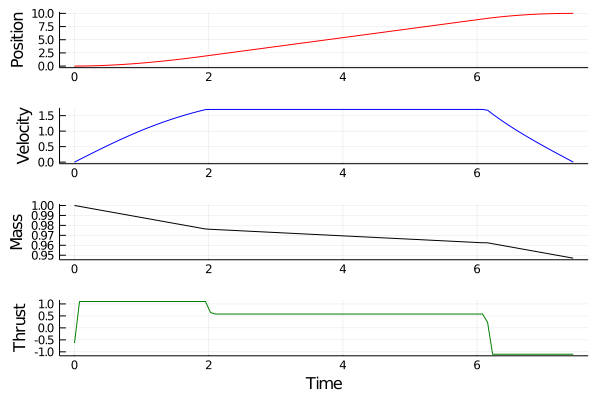

In [11]:
# Plot the results
p_1=plot(time_plot, s_plot, xaxis = "", yaxis = "Position", legend = false, color = :red);
p_2=plot(time_plot, v_plot, xaxis = "", yaxis = "Velocity", legend = false, color = :blue);
p_3=plot(time_plot, m_plot, xaxis = "", yaxis = "Mass", legend = false, color = :black);
p_4=plot(time_plot, u_plot, xaxis = "Time", yaxis = "Thrust", legend = false, color = :green);
plot(p_1, p_2, p_3, p_4, layout = (4,1))